In [53]:
%matplotlib inline
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
import os, sys
from PIL import Image
from sklearn.metrics import f1_score
import tensorflow as tf
import datetime

%load_ext autoreload
%autoreload 2
    
import ml_utils.road_seg as rs
import ml_utils.model as model
import ml_utils.data_augmentation as d_aug
from ml_utils.postprocessing import post_processing


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 1. Loading and Preprocessing

Load raw images and ground truth

In [54]:
path_data = 'data'
path_train_dir = os.path.join(path_data, 'training')
path_test = os.path.join(path_data, 'test_set_images')
path_models = 'model'


In [55]:
d_aug.genererate_data(path_train_dir, ratio=0.90, n_aug=500)



Split train set train/validation ...

Copy to sub folders ...

Generate augmented features - Train ...
Initialised with 90 image(s) found.
Output directory set to data/training/images/aug_train/.
Generate augmented features - Labels ...
Initialised with 90 image(s) found.
Output directory set to data/training/groundtruth/aug_train/.

In [56]:
train_imgs, train_gt, val_imgs, val_gt = rs.load_train_set(path_train_dir)

print('Shapes train: {},  test: {}'.format(train_imgs.shape, val_imgs.shape))
print('Shapes train: {},  test: {}'.format(train_gt.shape, val_gt.shape))


Loading train images ...
Loading train labels ...
Loading validation images ...
Loading validation labels ...
Shapes train: (590, 400, 400, 3),  test: (10, 400, 400, 3)
Shapes train: (590, 400, 400),  test: (10, 400, 400)


Generate smaller images for training

In [57]:
train_imgs = rs.normalize_data(train_imgs, mode='image_wise') 
val_imgs = rs.normalize_data(val_imgs, mode='image_wise') 
train_imgs, mean, std = rs.normalize_data(train_imgs, mode='all') 
val_imgs, _, _ = rs.normalize_data(val_imgs, mode='all', mean_ref = mean, std_ref = std) 

patch_size = 400
patch_tr, lab_tr,_ = rs.get_patches_all(train_imgs, train_gt, patch_size)

print('Shapes train: {}'.format(patch_tr.shape))
print('Shapes label: {}'.format(lab_tr.shape))


Shapes train: (590, 400, 400, 3)
Shapes label: (590, 400, 400)


Take only part of train and validation set (should at least contain a part of the road)

In [58]:
useful_patches_tr, useful_lab_tr = rs.get_useful_patches(patch_tr, lab_tr, 0.0, 1.0)
useful_lab_tr = useful_lab_tr.astype(int)

print('Shapes train: {}'.format(useful_patches_tr.shape))
print('Shapes lab: {}'.format(useful_lab_tr.shape))


Shapes train: (590, 400, 400, 3)
Shapes lab: (590, 400, 400)


Compute distance map

In [8]:
# useful_lab_tr_dn = rs.get_penalize_values(useful_lab_tr)


Display patches example with label ground truth and distance map

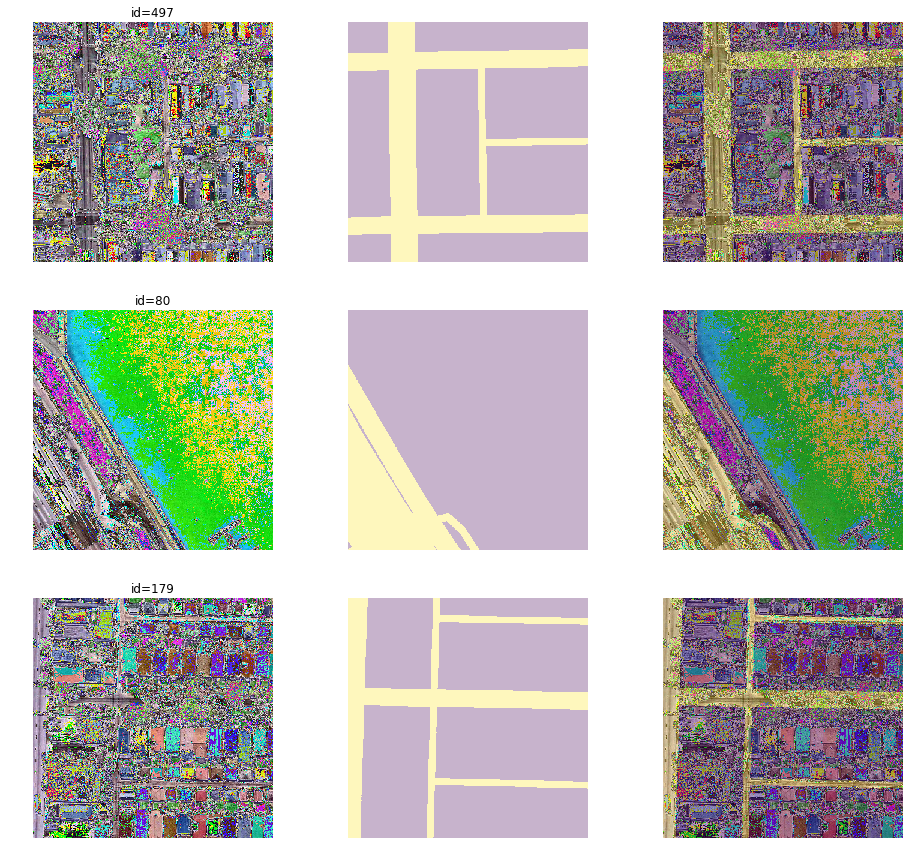

In [59]:
n_display = 3
id_display = np.random.permutation(len(useful_patches_tr))[:n_display]

plt.figure(figsize=(16, 5*n_display))
for i, id_ in enumerate(id_display):
    plt.subplot(n_display,3,3*i+1)
    plt.imshow(useful_patches_tr[id_]); plt.axis('off'); plt.title('id={}'.format(id_display[i]))
    plt.subplot(n_display,3,3*i+2)
    plt.imshow(useful_lab_tr[id_], alpha=0.3); plt.axis('off');
    plt.subplot(n_display,3,3*i+3)
    #plt.imshow(useful_patches_tr[id_]); plt.imshow(useful_lab_tr_dn[id_], alpha=0.3); plt.axis('off');
    plt.imshow(useful_patches_tr[id_]); plt.imshow(useful_lab_tr[id_], alpha=0.3); plt.axis('off');
    

# 2. Model training


In [10]:

# useful_patches_tr = normalize_data(useful_patches_tr, mode='image_wise') 

# Compute mean according to train image
# _, mean_train, std_train = rs.normalize_data(train_imgs, mode='all')

# Substract mean for
# patches
# upatches_tr_norm, _, _ = rs.normalize_data(useful_patches_tr, mode='all', mean_ref=mean_train, std_ref=std_train)
# train and validation
# train_imgs_norm, _, _ = rs.normalize_data(train_imgs, mode='all', mean_ref=mean_train, std_ref=std_train)
# val_imgs_norm, _, _ = rs.normalize_data(val_imgs, mode='all', mean_ref=mean_train, std_ref=std_train)

In [60]:
val_imgs.shape


(10, 400, 400, 3)

In [ ]:
import ml_utils.model as model

m = model.Model(n_filters=96)
m.train_model(useful_patches_tr, useful_lab_tr,
              train_imgs, train_gt, val_imgs=val_imgs, val_gt=val_gt, n_epoch=40, display_epoch=1)
# nmax need to be bigger or eq than the smallest number of elements, e.g. size of validation set 


conv1 size (?, ?, ?, 96)
pool1 size (?, ?, ?, 96)
conv2 size (?, ?, ?, 192)
pool2 size (?, ?, ?, 192)
conv3 size (?, ?, ?, 384)
pool3 size (?, ?, ?, 384)
conv4 size (?, ?, ?, 768)
pool4 size (?, ?, ?, 768)
deconv1 size (?, ?, ?, 768)
deconv2 size (?, ?, ?, 384)
deconv3 size (?, ?, ?, 192)
deconv4 size (?, ?, ?, 96)
score size (?, ?, ?, 2)
Computing devices: 
/device:CPU:0
/device:GPU:0
/device:GPU:1


/home/patryk_oleniuk/miniconda3/envs/my-amazing-working-gpu/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Recap epoch 1 is 343.1059s
	 last minibatch, loss :  0.575817 cross entropy :  0.437172 reg term :  0.138644


/home/ML_course/projects/project2/project_road_segmentation/ml_utils/model.py:182: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if(val_imgs != None) and (val_gt != None):


	 val_loss :  0.621697127819 , train_loss :  0.596428774171
	 val f1 :  0.439429282953 , train f1 :  0.444935910707
	 val f1 postproc :  0.439429282953 , train f1 postproc :  0.444935910707
Recap epoch 2 is 338.5153s
	 last minibatch, loss :  0.600836 cross entropy :  0.488728 reg term :  0.112108
	 val_loss :  0.603976309299 , train_loss :  0.575941112082
	 val f1 :  0.439429282953 , train f1 :  0.444935910707
	 val f1 postproc :  0.439429282953 , train f1 postproc :  0.444935910707


/home/patryk_oleniuk/miniconda3/envs/my-amazing-working-gpu/lib/python3.5/site-packages/skimage/morphology/misc.py:122: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
  warn("Only one label was provided to `remove_small_objects`. "


Recap epoch 3 is 340.7068s
	 last minibatch, loss :  0.294057 cross entropy :  0.202911 reg term :  0.091146
	 val_loss :  0.434045225382 , train_loss :  0.395682622316
	 val f1 :  0.794103602252 , train f1 :  0.794982863268
	 val f1 postproc :  0.795499338557 , train f1 postproc :  0.797176693045
Recap epoch 4 is 340.8746s
	 last minibatch, loss :  0.455635 cross entropy :  0.380461 reg term :  0.0751743
	 val_loss :  0.370041847229 , train_loss :  0.30281783211
	 val f1 :  0.818749756721 , train f1 :  0.848678972493
	 val f1 postproc :  0.820236179385 , train f1 postproc :  0.850416150029
Recap epoch 5 is 340.3877s
	 last minibatch, loss :  0.214168 cross entropy :  0.150942 reg term :  0.0632263
	 val_loss :  0.337948739529 , train_loss :  0.254523262382
	 val f1 :  0.80821269317 , train f1 :  0.87194614462
	 val f1 postproc :  0.80615256758 , train f1 postproc :  0.872514534094
Recap epoch 6 is 340.0594s
	 last minibatch, loss :  0.212492 cross entropy :  0.158187 reg term :  0.054

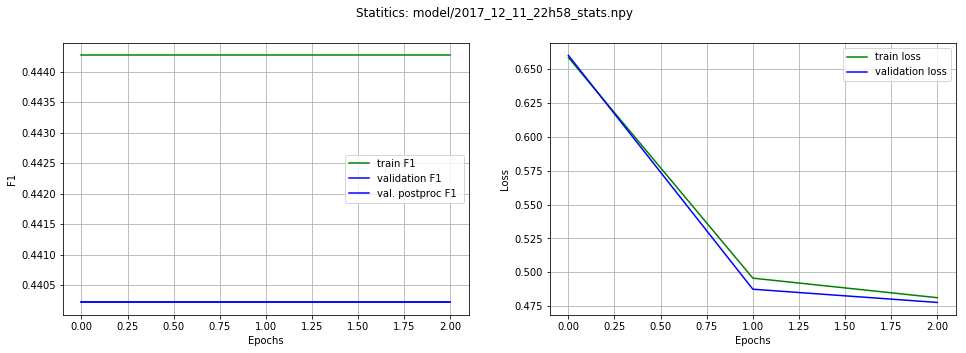

In [50]:
m.plot_stats(_file='model/2017_12_11_22h58_stats.npy')


# 3. Results vizualisation


INFO:tensorflow:Restoring parameters from model/2017_12_11_20h48_model.ckpt


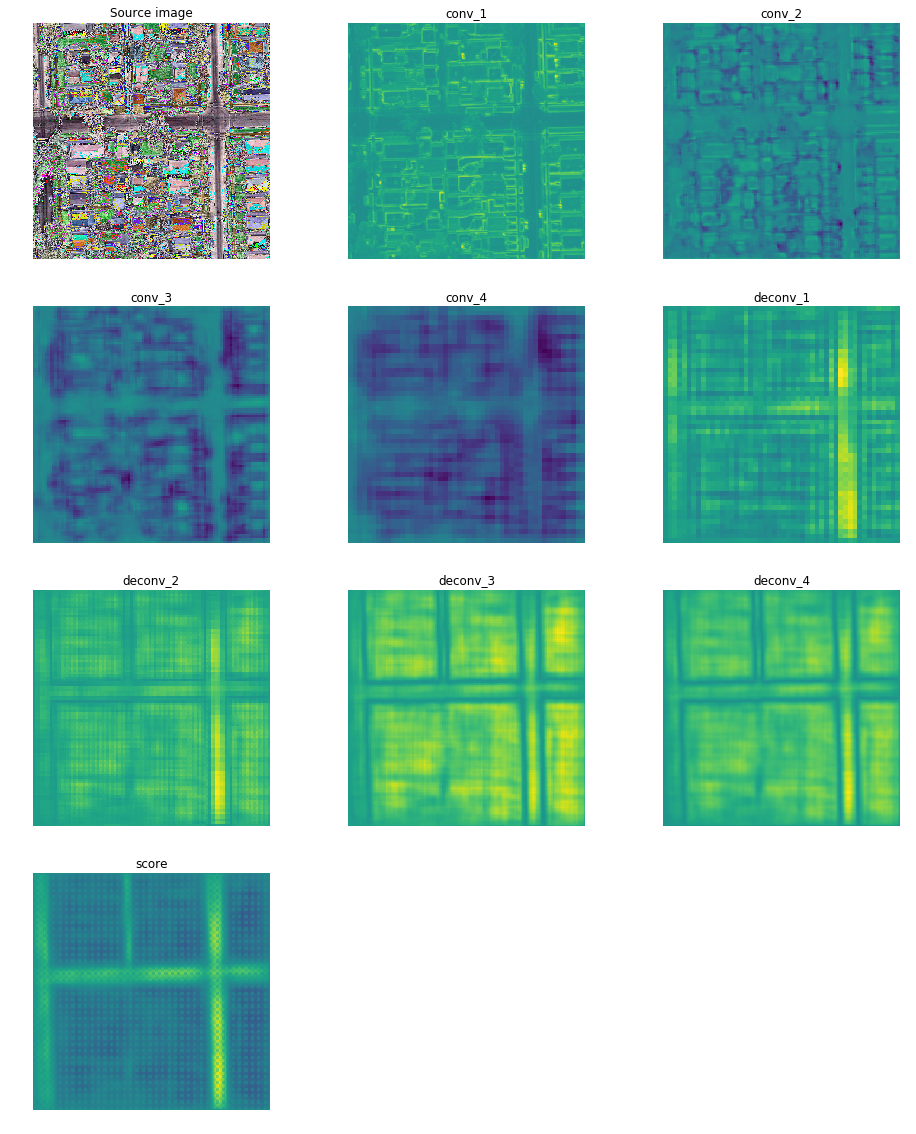

In [24]:
m = model.Model(display_log=False, kernel_size=5, reg=2e-2)
d = m.get_model_layers(train_imgs[2], 'model/2017_12_11_20h48_model.ckpt')
m.plot_layers(train_imgs[2], d)


In [26]:
y_pred_train = m.apply_model(train_imgs, 'model/2017_12_11_20h48_model.ckpt')
print('F1-score train: {}'.format(m.predict_f1(train_gt, y_pred_train)))
y_pred_valid = m.apply_model(val_imgs, 'model/2017_12_11_20h48_model.ckpt')
print('F1-score validation: {}'.format(m.predict_f1(val_gt, y_pred_valid)))



INFO:tensorflow:Restoring parameters from model/2017_12_11_20h48_model.ckpt
F1-score train: 0.9750500908615187
INFO:tensorflow:Restoring parameters from model/2017_12_11_20h48_model.ckpt
F1-score validation: 0.841237194959773


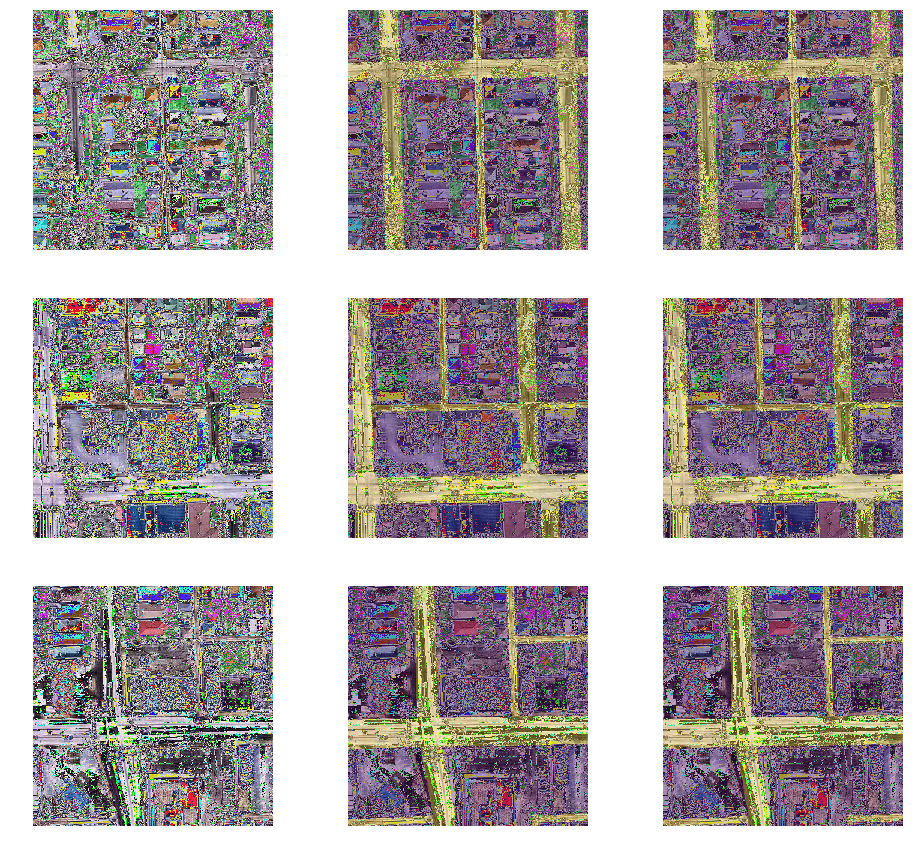

In [27]:
rs.display_predictions(y_pred_train, train_imgs, train_gt)


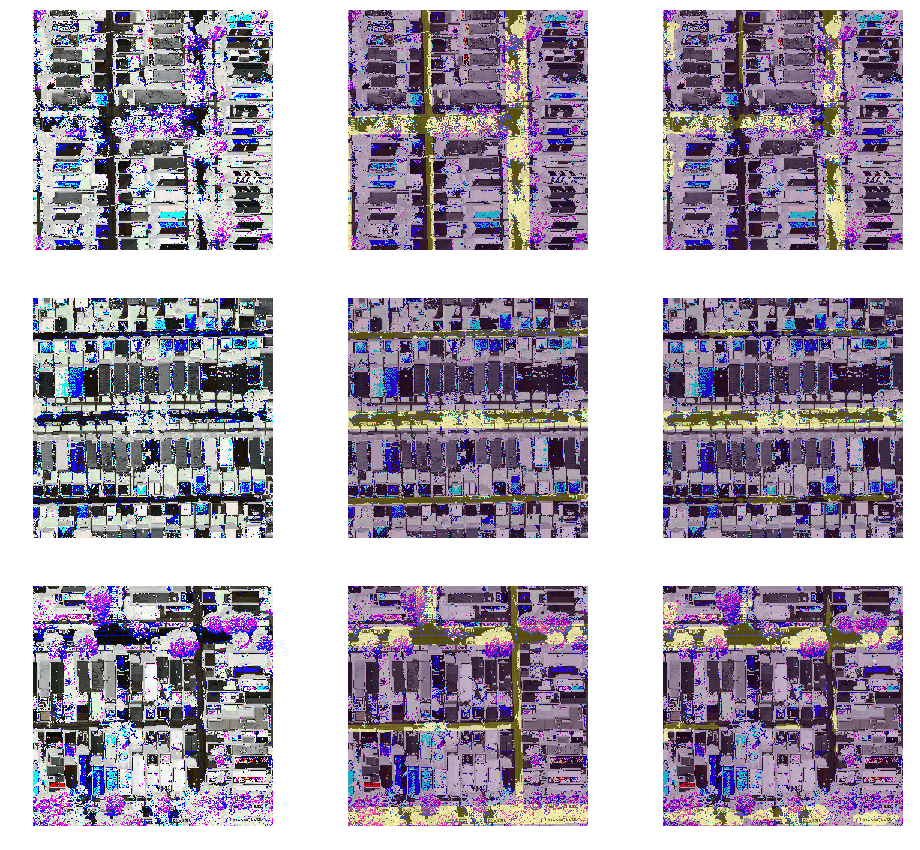

In [28]:
rs.display_predictions(y_pred_valid, val_imgs, val_gt)


# 4. Post Process

In [14]:
test_img = rs.load_test_set(path_test)
test_img_norm, _, _ = rs.normalize_data(test_img, mode='all', mean_ref=mean, std_ref=std)

test_img_norm.shape


(50, 608, 608, 3)

In [15]:
m = model.Model(display_log=False)
y_pred_test = m.apply_model(test_img_norm, 'model/2017_12_10_23h54_model.ckpt')

INFO:tensorflow:Restoring parameters from model/2017_12_10_23h54_model.ckpt


(50, 608, 608, 3)


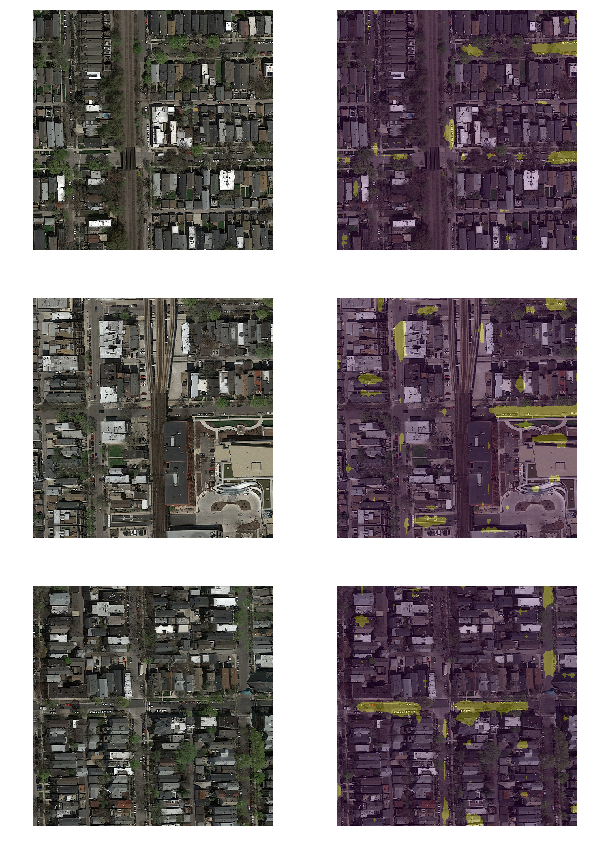

In [16]:
im_pred_test = np.reshape(y_pred_test, test_img.shape[:3]).astype(np.float32)
print(test_img.shape)
rs.display_predictions(y_pred_test, test_img)

In [ ]:
m = model.Model(display_log=False)
y_pred_val = m.apply_model(val_imgs, 'model/2017_12_09_20h51_model.ckpt')
im_pred_val = np.reshape(y_pred_val, val_imgs.shape[:3]).astype(np.float32)
print(val_imgs.shape)
rs.display_predictions(y_pred_val, val_imgs)

In [34]:


# by sweep the best value is 400
im_pred_test_post = post_processing(im_pred_test, 400)

NameError: name 'im_pred_test' is not defined

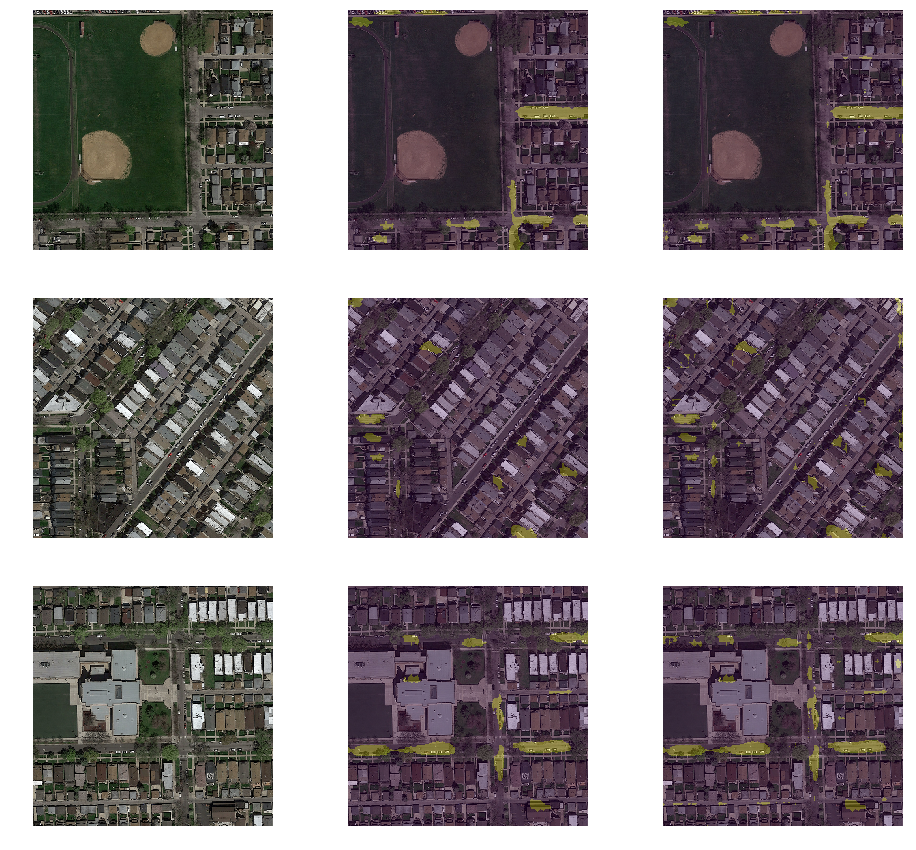

In [19]:
rs.display_predictions(y_pred_test, test_img, im_pred_test_post)

# 4. Submission

In [74]:
rs.create_submission(im_pred_test_post, 'test_30epoch_post400_dataaug500full.csv')